In [1]:
# import the required modules
import torch 
from torch import nn
from torch.optim import Adam
import librosa
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import os
import time
from skimage.transform import resize 
device = "cuda" if torch.cuda.is_available() else 'cpu'

In [17]:
df = pd.read_csv('/kaggle/input/quran-recitations-for-audio-classification/files_paths.csv')
df.head()

,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan
2,./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav,Mohammed_Aluhaidan
3,./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav,Mohammed_Aluhaidan
4,./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav,Mohammed_Aluhaidan


<Axes: xlabel='Class'>

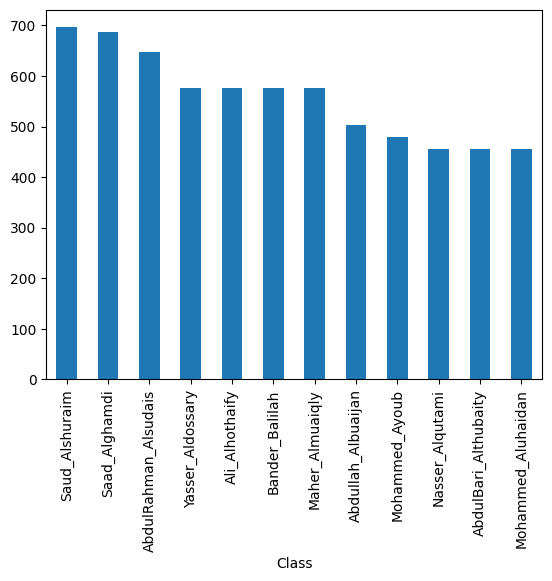

In [18]:
df['Class'].value_counts().plot(kind='bar')

* this dataset is not completely balanced

In [19]:
df['FilePath'] = '/kaggle/input/quran-recitations-for-audio-classification/Dataset' + df['FilePath'].str[1:]

In [22]:
# splitting the data into training, validation, testing 
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    df['FilePath'], df['Class'],
    test_size=0.3, shuffle=True, stratify=df['Class']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val,
    test_size=0.5, shuffle=True, stratify=y_val
)

# Option 1: reset index
X_train = X_train.reset_index(drop=True)
X_val   = X_val.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val   = y_val.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

In [26]:
# Fit our encoder for Class 
label_encoder = LabelEncoder()
label_encoder.fit(df['Class'])

LabelEncoder()

In [29]:
# create the custom class
class CustomAudioDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = torch.tensor(label_encoder.transform(y)).type(torch.LongTensor)
        self.audios = [torch.tensor(self.get_spectogram(path)).type(torch.FloatTensor) for path in x]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        file_path = self.x[index]
        label = self.y[index]
        audio = self.audios[index].unsqueeze(0)
        return audio, label
    def get_spectogram(self, file_path):
        sr = 22050
        duration = 5
        img_height = 128
        img_width = 256
        signal, sr = librosa.load(file_path, sr = sr, duration = duration)
        spc = librosa.feature.melspectrogram(y = signal, sr = sr, n_fft = 2048, hop_length = 512, n_mels = 128)
        spec_db = librosa.power_to_db(spc, ref = np.max)
        spec_resized = librosa.util.fix_length(spec_db, size = (duration*sr)//512+1)
        spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing = True)
        return spec_resized
        

In [31]:
# Creating the dataset for train, val, test
train_dataset = CustomAudioDataset(X_train, y_train)
val_dataset   = CustomAudioDataset(X_val,   y_val)
test_dataset  = CustomAudioDataset(X_test,  y_test)

In [35]:
# new lets determine the learning prams
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

In [36]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=4, pin_memory=True)
val_loader = val_loader = DataLoader(val_dataset, batch_size=32,num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [38]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pooling = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear((64*16*32), 4096)
        self.linear2 = nn.Linear(4096, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.output = nn.Linear(512, 12)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.conv3(x)
        x = self.pooling(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.relu(self.linear3(x))
        x = self.dropout(x)
        x = self.output(x)
        return x



In [39]:
model = Net().to(device)

In [40]:
from torchsummary import summary 
summary(model, input_size=(1, 128,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
            Conv2d-3          [-1, 32, 64, 128]           4,640
         MaxPool2d-4           [-1, 32, 32, 64]               0
            Conv2d-5           [-1, 64, 32, 64]          18,496
         MaxPool2d-6           [-1, 64, 16, 32]               0
              ReLU-7           [-1, 64, 16, 32]               0
           Flatten-8                [-1, 32768]               0
            Linear-9                 [-1, 4096]     134,221,824
             ReLU-10                 [-1, 4096]               0
          Dropout-11                 [-1, 4096]               0
           Linear-12                 [-1, 1024]       4,195,328
             ReLU-13                 [-1, 1024]               0
          Dropout-14                 [-

In [41]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [42]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS +1):
    model.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        # move batch to GPU
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        pred_img = model(images)
        loss = loss_fun(pred_img , labels)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item() * images.size(0)
        preds = pred_img.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    train_loss = train_running_loss / train_total
    train_acc = train_correct / train_total

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # move batch to GPU
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fun(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total if val_total > 0 else 0.0
    val_acc = val_correct / val_total if val_total > 0 else 0.0

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train loss: {train_loss:.4f}, Train acc: {train_acc*100:.2f}% | "
          f"Val loss: {val_loss:.4f}, Val acc: {val_acc*100:.2f}%")

Epoch 1/25 | Train loss: 2.5295, Train acc: 14.25% | Val loss: 2.0876, Val acc: 49.65%
Epoch 2/25 | Train loss: 1.4768, Train acc: 50.04% | Val loss: 0.5360, Val acc: 83.45%
Epoch 3/25 | Train loss: 0.6045, Train acc: 80.49% | Val loss: 0.1956, Val acc: 94.12%
Epoch 4/25 | Train loss: 0.2641, Train acc: 91.84% | Val loss: 0.0890, Val acc: 97.91%
Epoch 5/25 | Train loss: 0.1463, Train acc: 95.58% | Val loss: 0.0626, Val acc: 98.40%
Epoch 6/25 | Train loss: 0.0906, Train acc: 97.05% | Val loss: 0.0614, Val acc: 97.81%
Epoch 7/25 | Train loss: 0.0698, Train acc: 97.99% | Val loss: 0.0511, Val acc: 98.50%
Epoch 8/25 | Train loss: 0.0547, Train acc: 98.29% | Val loss: 0.0683, Val acc: 98.11%
Epoch 9/25 | Train loss: 0.0461, Train acc: 98.68% | Val loss: 0.0430, Val acc: 98.80%
Epoch 10/25 | Train loss: 0.0260, Train acc: 99.25% | Val loss: 0.0564, Val acc: 98.21%
Epoch 11/25 | Train loss: 0.0358, Train acc: 98.95% | Val loss: 0.0529, Val acc: 98.90%
Epoch 12/25 | Train loss: 0.0448, Train a

In [43]:
with torch.no_grad():
    total_acc_test = 0
    total_samples = 0
    for images, labels in test_loader:
        # move batch to GPU
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        acc = (preds == labels).sum().item()
        total_acc_test += acc
        total_samples += labels.size(0)
    accuracy = total_acc_test / total_samples
    print("Test Accuracy:", accuracy)

Test Accuracy: 0.9900398406374502


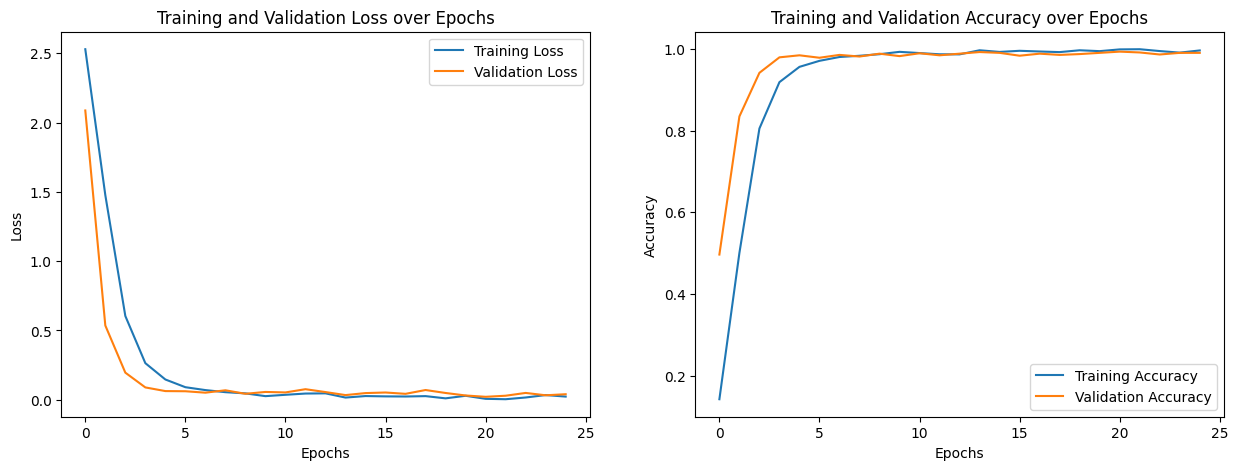

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(history["train_loss"], label='Training Loss')
axs[0].plot(history["val_loss"], label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(history["train_acc"], label='Training Accuracy')
axs[1].plot(history["val_acc"], label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
